In [1]:
!pip install psycopg2

In [4]:
import sys
sys.path.append('..\\sif_research\\data_utils')

import sif_utils as su
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import importlib
import seaborn # optional
seaborn.set() # optional
plt.rcParams['figure.figsize'] = [10, 6] # increase figure size


# Adds the research_framework folder to system path so python knows to look their for imports
sys.path.append('..\\sif_research\\research_framework') # CHANGE FOR MAC OS

import metrics

## Use code from backtest example to load data ##

In [9]:
# Global Variables / Research Environment Settings
start_date = datetime.datetime(day=3, month=1, year=2012)
end_date = datetime.datetime(day=1, month=1, year=2017)
days = (end_date - start_date).days

# Number of stocks to have in the universe
top_N = 100

In [10]:
# Grab all tickers in the universe
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))

In [11]:
# Pull data needed for research and store into variables, or however
# you want to handle your data.

# This is the order of the parameters, once you are comfortable feel free
# to not use paramater=foo and just do foo, bar, ...

price_attrs = ['open', 'close', 'low', 'high']
data = su.get_equity_data(tickers=tickers, start_date=start_date, end_date=end_date,
                          attributes=price_attrs)

In [12]:
# Convert from dictionary of dataframes to numpy arrays

OPEN = data['open'].astype(float).values
CLOSE = data['close'].astype(float).values
LOW = data['low'].astype(float).values
HIGH = data['high'].astype(float).values

In [13]:
universe_filter = su.create_universe_filter(top_N, start_date, end_date, tickers, data['close'].index.values)

In [14]:
# Fills all the tickers not in the universe at that point with 0
FILLED_CLOSE = metrics.fill_nonuniverse(universe_filter.values, CLOSE, fill_val=0)

## My strategy going here ##

In [15]:
def strategy(day):
    """
    Attempting to implement basic mean reversion strategy
    :return: numpy array of shape: 1 x len(Universe) with equity holdings
    """
   

In [16]:
# compute holdings
universe_size = len(tickers)
holdings = metrics.backtest(strategy, CLOSE.shape[0], universe_size, lookback)
print(f'Holdings Shape: {holdings.shape}')

NameError: name 'lookback' is not defined

## Starting again with stuff from Hao's notebook ##

In [4]:
!pip install psycopg2

In [4]:
import sys
import pandas as pd
import numpy as np
import datetime
sys.path.append('..\\sif_research\\research_framework')
import metrics
import os
from operators import rank, ts_rank, group_rank, weight


sys.path.append('..\\sif_research\\data_utils')

import sif_utils as su

In [19]:
# Global Variables / Research Environment Settings
start_date = datetime.datetime(day=1, month=1, year=2012)
end_date = datetime.datetime(day=1, month=1, year=2017)
days = (end_date - start_date).days
lookback = 20
delay = 1
top_N = 300
initial_investment = 1000
save_backtest_result = True
backtest_result_folder = './backtest_result'
# Get all tickers
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))

In [20]:
# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)

price_attrs = ['open', 'close', 'low', 'high', 'volume']
data = su.get_equity_data(tickers=tickers, start_date=start_date,
                          end_date=end_date, attributes=price_attrs)


In [21]:
OPEN = data['open'].astype(float).values
CLOSE = data['close'].astype(float).values
LOW = data['low'].astype(float).values
HIGH = data['high'].astype(float).values
VOLUME = data['volume'].astype(float).values

# Create universe filter table
all_dates = data['close'].index.values
universe_filter = su.create_universe_filter(top_N, start_date, end_date, tickers, all_dates)

# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)
universe_filter_arr = universe_filter.values

In [22]:
data.keys()

dict_keys(['open', 'close', 'low', 'high', 'volume'])

In [23]:
# Hao's example alpha
def alpha(day):
    # raw factor computed for all tickers (not necesarily the valid universe)
    factor = -rank(CLOSE[day - delay] - CLOSE[day - delay - 4])
    return weight(factor, universe_filter_arr[day])

In [75]:
# The idea of combining gain and acceleration to estimate future returns
# If a stock has had positive returns and is 
def momentum_alpha(day, gain_lb=4, acc_lb=10):
    acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
    weekly_gain = -rank(CLOSE[day - delay] - CLOSE[day - delay - gain_lb])
    
    factor = weekly_gain + acceleration
    return weight(factor, universe_filter_arr[day])

In [73]:
def test_diff_lookbacks(gain_lbs=[5], acc_lbs=[20]):
    for gain_lb in gain_lbs:
        for acc_lb in acc_lbs:
            def momentum_alpha(day):
                acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
                weekly_gain = -rank(CLOSE[day - delay] - CLOSE[day - delay - gain_lb])

                factor = weekly_gain + acceleration
                return weight(factor, universe_filter_arr[day])
            # run backtest, print the performance table and draw the chart
            # For skew momentum
            lookback = 20
            holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
            daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
            performance = metrics.generate_performance_table(daily_returns, holdings,
                                                             dates=all_dates[lookback:-1],
                                                            tickers=tickers)
            print(f'Gain lb: {gain_lb}, Acc lb: {acc_lb}')
            rets = performance['return'].iloc[5]
            shp = performance['sharpe'].iloc[5]
            srt = performance['sortino'].iloc[5]
            print(f'Total returns: {rets} , Sharpe: {shp} , Sortino: {srt}')

            
gain_lbs=[3, 4, 5, 6, 7, 8]
acc_lbs=[10,15,20,25,30]
test_diff_lookbacks(gain_lbs, acc_lbs)


# pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
# chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


C:\Users\erueb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Gain lb: 3, Acc lb: 10
Total returns: 0.19488975560502164 , Sharpe: 1.0734992428185743 , Sortino: 1.6154413928153628
Gain lb: 3, Acc lb: 15
Total returns: 0.16435377449834151 , Sharpe: 0.8956993459419518 , Sortino: 1.3409530178027533
Gain lb: 3, Acc lb: 20
Total returns: 0.17559301933684887 , Sharpe: 0.9511166054572013 , Sortino: 1.4366250162413785
Gain lb: 3, Acc lb: 25
Total returns: 0.1768346903252755 , Sharpe: 0.951898288975091 , Sortino: 1.4374969317077897
Gain lb: 3, Acc lb: 30
Total returns: 0.19609698898267897 , Sharpe: 1.0605290783632353 , Sortino: 1.611521827639315
Gain lb: 4, Acc lb: 10
Total returns: 0.2298375394863399 , Sharpe: 1.26441779283994 , Sortino: 1.9361689482485607
Gain lb: 4, Acc lb: 15
Total returns: 0.1888554823339615 , Sharpe: 1.0172101828709799 , Sortino: 1.5506024028563454
Gain lb: 4, Acc lb: 20
Total returns: 0.20310126440176596 , Sharpe: 1.0802058985497824 , Sortino: 1.6555270393783252
Gain lb: 4, Acc lb: 25
Total returns: 0.21252520383274218 , Sharpe: 1.1

In [35]:
def skew_momentum_alpha(day):
    # Using the max daily return from the past 3 months to represent skew
#     print(day)
    skew_start = day - delay - 20
    skew_end = day
#     print(f'Skew start: {skew_start} , skew end: {skew_end}')
    daily_rets = CLOSE[skew_start:skew_end] - OPEN[skew_start:skew_end]
    
    skew = rank(np.amax(daily_rets, axis=0))

    # Using return from the past 3 months as momentum
    momentum = rank(CLOSE[day - delay] / CLOSE[day - delay - 252])

    # We believe that stocks with either high skew and negative momentum OR stocks with low skew and positive momentum are the stocks we want to long
    # These stocks are said to have "enhanced momentum"
    # High skew neg momentum signifies a stock that is currently undervalued?, as in its current pricing represents a negative outlier value and it will revert to the mean
    # Low skew pos momentum signifies a stock that is currently performing well and appears to be performing around its average, therefore this stock is a good buy as 
    #    we expect it to continue on this trend

    # Simple and likely nonoptimal way to try to find these stocks with mixed skew/momentum high/low or low/high is to add their ranked arrays together
        # Side note, could weight the momentum vs. skew arrays differently to see if that changes anything
    # Since the rankings are both equal, (rank assigns a percentile to each ticker), The combination of skew/momentum high/high will be closer to 2 and low/low will be closer to 0, 
    # so we want middling values

    # In a simple effort to address this, we rank the values in the combined array of skew and momentum by each elements absolute difference from 1
    # (i.e. -rank by abs diff to ensure that the lowest abs diff is ranked highest)
#         combined = skew + momentum
#     #     print(combined)
#         factor = -rank(abs(combined - 1))
#         return weight(factor, universe_filter_arr[day])

    # Trying paper's approach for ranking
    # Take stocks that are in the top quintile of skew and bottom quintile of momentum or in the bottom quintile of skew and top quintile of momentum
    factor = np.zeros(len(skew))
#     print(skew)
#     print(momentum)
    for i in range(0, len(skew)):
        if((skew[i] >= .8 and momentum[i] <= .2) or (skew[i] <= .2 and momentum[i] >= .8)):
            # Long the stock
            factor[i] = abs(skew[i] - momentum[i])
        else:
            factor[i] = 0
    # Inverting the factor gives much better returns???
    # Did I get something backwards???
    return weight(factor, universe_filter_arr[day])

In [ ]:
# The idea is to include returns, change in returns, and change in change in returns as stats to look at 
def convex_concave(day):
    

In [13]:
def long_all(day):
    all_long = np.zeros(318)
    all_long.fill(1/300)
    return all_long

In [34]:
skew_momentum_alpha(346)

array([ 0.        , -0.00180505, -0.00180505,  0.        ,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        ,  0.        ,
        0.        , -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505, -0.00180505,  0.02173913, -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
        0.        ,  0.        , -0.00180505, -0.00180505,  0.        ,
       -0.00180505,  0.        ,  0.02173913, -0.00180505, -0.00180505,
        0.        , -0.00180505, -0.00180505, -0.00180505,  0.02173913,
        0.        , -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.02173913, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
       -0.00180505, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.        , -0.00180505,  0.        ,  0.02173913, -0.00

In [80]:
# Can do something with close to open overnight
def overnight(day):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-80-d8fb8771adf2>, line 3)

### Some notes from meeting 2/24/2020 to possibly make alphas ### 

 Momentum again from video from 2/24/2020
 
 Look at convexity and concavity
 
 y = Gain * t + Acc * x^2
 
 Accelerated vs decelerated gain
 
 Whether coefficients are positive or negative
 
 Approximating curves with polynomials

 Skewness and momentum
 Skewness as a signal for stocks that are overbrought

Proxy for skew, max daily return from past 20 days/ past month (positive skew)
    Could also do negative skew with minimum

Assume return over trailing year as momentum

More strongly positive skew and positive momentum represents weakened momentum

Positive momentum and less skew is enhanced momentum

Negativee momentum and positive skew is enhanced momentum

Negative momenutum and less skew is weakened momentum

Ideas for fundamanetal frm Hao
   
   Rank ( equity/ assets) <-- cross sectional
   
   ts_rank(-debt/equity, 252 <-- or whatever lookback) <-- ts_info
   
   abs(eps[day - 1] - eps[day - 2]) > 0 <-- check to see if comany updated financial statements
   
       Include mean reversion/momentum factor and combine with this to build an alpha

           return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2012     0.049179  1.409011  2.154220 -0.026279  0.728533  142.869565   
2013     0.042948  1.712719  2.628185 -0.020426  0.728120  143.055556   
2014     0.055016  1.550198  2.499900 -0.033305  0.726374  141.829365   
2015     0.038436  0.960367  1.442035 -0.029360  0.745499  141.857143   
2016     0.048745  1.054447  1.592487 -0.029889  0.714794  138.191235   
Overall  0.229838  1.264418  1.936169 -0.039322  0.729745  141.538772   

         short count  
year                  
2012      156.078261  
2013      155.543651  
2014      156.000000  
2015      154.087302  
2016      149.924303  
Overall   154.291599  


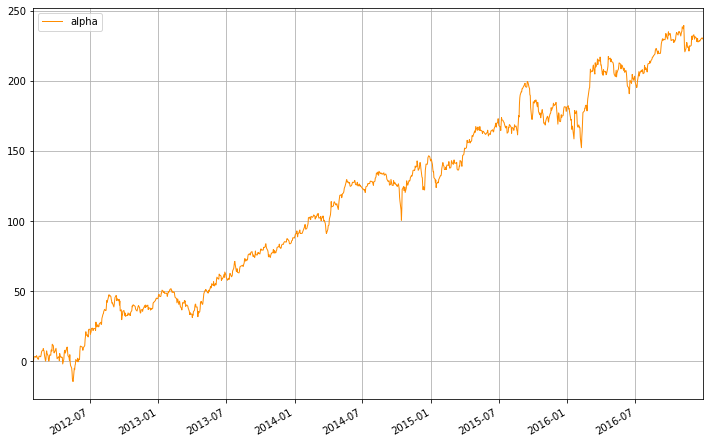

In [76]:
# run backtest, print the performance table and draw the chart
# For skew momentum
lookback = 20
holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
performance = metrics.generate_performance_table(daily_returns, holdings,
                                                 dates=all_dates[lookback:-1],
                                                tickers=tickers)
print(performance)
# print(performance['return'].iloc[5])
pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


In [16]:
# save backtest result
if save_backtest_result == True:
    if not os.path.exists(backtest_result_folder):
        os.makedirs(backtest_result_folder)
    pnl_df.to_csv(backtest_result_folder+'/'+'pnl.csv')
    pd.DataFrame(holdings[:-1],index = data['close'].iloc[lookback:-1].index, columns = tickers).to_csv(backtest_result_folder+'/'+'holdings.csv')
    chart.get_figure().savefig(backtest_result_folder+'/'+'performance.png')
        